# Frequency Distributions 

A random variable $N$ is **$G$-mixed Poisson** if $N\mid G$ has a Poisson $nG$ 
distribution for some fixed non-negative $n$ and a non-negative mixing distribution 
$G$ with $\text{E}(G)=1$. Let $\text{Var}(G)=c$ (Glenn Meyers calls $c$ the contagion) and let $\text{E}(G^3)=\gamma$. 

The MGF of a $G$-mixed Poisson is
$$\label{mgfi}
M_N(\zeta)=\text{E}(e^{\zeta N})=\text{E}(\text{E}(e^{\zeta N} \mid G))=\text{E}(e^{n
  G(e^\zeta-1)})=M_G(n(e^\zeta-1))
$$ 
since $M_G(\zeta):=\text{E}(e^{\zeta G})$ and the MGF of a Poisson with mean $n$ is $\exp(n(e^\zeta-1))$. 
Thus 
$$
\text{E}(N)=M_N'(0)=n M_G'(0)=n,
$$
because $\text{E}(G)=M_G'(0)=1$. Similarly
$$
\text{E}(N^2)=M_N''(0)=n^2M_G''(0)+n M_G'(0)=n^2(1+c)+n
$$ 
and so
$$
\text{Var}(N)=n(1+cn).
$$ 
Finally
$$
\text{E}(N^3) = M_N'''(0) =n^3M_G'''(0)+3n^2M_G''(0)+n M_G'(0)
$$ 
and therefore the central moment
$$
\text{E}(N-\text{E}(N))^3 = n^3(\gamma -3c -1) + n^2(3c+2) + n.
$$

We can also assume $G$ has mean $n$ and work directly with $G$ rather
than $nG$, $\text{E}(G)=1$. We will call both forms mixing distributions.

## Gamma Mixing

A negative binomial is a gamma-mixed Poisson: if $N \mid G$ is
distributed as a Poisson with mean $G$, and $G$ has a gamma
distribution, then the unconditional distribution of $N$ is a negative
binomial. A gamma distribution has a shape parameter $a$ and a scale parameter $\theta$
so that the density is proportional to $x^{a-1}e^{x/\theta}$, $\text{E}(G)=a\theta$ and 
$\text{Var}(G)=a\theta^2$. Hence if $c=\nu^2$, $\nu$ the coefficient of variation of 
the mixing distribution (which corresponds to the asymptotic coefficient of variation for any 
$G$-mixed compound Poisson distribution if variance of severity exists) then 

* $a\theta=1$ and $a\theta^2=c$
* $\theta=c=\nu^2$, $a=1/c$

For the gamma distribution $\text{E}(G^r)=\theta\Gamma(a+r)/\Gamma(a)$. Therefore 
$$
Var(G) = a\theta^2 \qquad E(G-E(G))^3 = 2a\theta^3
$$
and the skewness is $\gamma = 2/\sqrt(a) = 2\nu$. Applying the general formula for the third
central moment of $N$ we get an expression for the skewness
$$
\text{skew} = \frac{n^3(\gamma -3c -1) + n^2(3c+2) + n}{(n(1+cn))^{3/2}}.
$$

## Shifted Mixing (General) 

We can adjust the skewness of mixing with shifting. Given a target CV $\nu$ and skewness $m\gamma$ (relative 
to an unshifted skewness $\gamma$) we can want to find $s$ and $G'$ so that $G=s+G'$ has

* expected value 1, i.e. $E(G')=1-s$
* CV $\nu$, i.e. $SD(G) = SD(G') = \nu$
* and skewness equal to $m\gamma$

If $N$ is a $s+G'$ mixed Poisson then the moments of $N$ are

* $E(N) = 

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.core.display import HTML, display
from importlib import reload
import scipy.stats as ss

# pandas options 
pd.set_option('max_rows', 50)
pd.set_option('max_columns', 30)
pd.set_option('display.max_colwidth', 150)

# matplotlib and plotting options 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# seaborn options 
sns.set(context='paper', style='darkgrid', font='serif')
# sns.set(context='paper', style='ticks', font='serif')

# warnings
import warnings
# warnings.simplefilter('error')
# warnings.simplefilter('ignore')

# this file is in examples
import sys
sys.path.insert(0,'/s/telos/python/aggregate_project/')
import aggregate as agg

import aggregate.parser as parser
import aggregate.underwriter as trash
uw = trash.Underwriter(debug=False)
from aggregate.utils import sgamma_fit, MomentAggregator


In [3]:
ft = lambda x: np.fft.fft(x)

ift = lambda x : np.fft.ifft(x)

In [121]:
def gamma_mix(n, cv, skew_mult, log2, **kwds):
    
    def defuzz(x):
        x[np.abs(x) < 5e-16] = 0
        return x
    
    N = 1 << log2
    z = np.zeros(N)
    z[1] = 1
    fz = ft(z)
    # build poisson for comparison
    kernel = n * (fz - 1)
    p = np.real(ift(np.exp(kernel)))
    p = defuzz(p)
    
    # Var(G) = c, E(G)=1 so Var(G) = cv^2
    c = cv*cv
    # wikipedia / scipy stats use a and theta for shape and scale
    a = 1 / c
    θ = c
    nb = np.real(ift( (1 - θ * kernel) ** -a))
    nb = defuzz(nb)
    
    sh, a2, θ2 = sgamma_fit(1, cv, 2 * cv * skew_mult)
    # by hand gamma=target skewness
    γ = skew_mult * 2 * cv 
    a_ = 4 / (γ * γ)
    θ_ = cv * γ / 2
    sh_ = 1 - 2 * cv / γ
    print(f'{sh}={sh_}\t {a2}={a_}\t {θ2}={θ_}')
    
    delaporte = np.real(ift( np.exp(sh * kernel) *  (1 - θ2 * kernel) ** -a2))
    delaporte = defuzz(delaporte)
    
    df = pd.DataFrame(dict(x=range(N), poisson=p, negbin=nb, delaporte=delaporte))
    df.plot(kind='line', x='x', **kwds)

    # moments 
    moms = lambda col :  ((df.x**k * df[col]).sum() for k in (1,2,3))
    pm1, pm2, pm3 = moms('poisson') 
    pm, pcv, psk = MomentAggregator._moments_to_mcvsk(pm1, pm2, pm3)
    nbm1, nbm2, nbm3 = moms('negbin')
    nbm, nbcv, nbsk = MomentAggregator._moments_to_mcvsk(nbm1, nbm2, nbm3)
    dm1, dm2, dm3 = moms('delaporte')
    dm, dcv, dsk = MomentAggregator._moments_to_mcvsk(dm1, dm2, dm3)
    
    # asymptotic moments 
    asNCV = np.sqrt(1/n + c)
    asNSK = 2 * cv
    
    # direct calc of delaporte moments
    eg3 = 2 * skew_mult * cv**4 + 3*c + 1  # γ * c**(3/2) + 3 * c + 1
    eg2 = 1 + c
    en3 = n**3 * eg3  + 3 * n*n * eg2 + n   
    # this is central: n**3 * (γ + 3 * c - 1) + n * n * (3 * c + 2) + n 
    en2 = n*n*(1+c) + n
    en = n
    dirm, dircv, dirsk = MomentAggregator._moments_to_mcvsk(en, en2, en3)
    print(f'{dm}={dirm}\t{dcv}={dircv}\t{dsk}={dirsk}')
    
    temp = pd.DataFrame(dict(cv=cv, skew_mult=skew_mult, a=a, θ=θ, sh=sh, a2=a2, θ2=θ2, 
                             pm=pm, pcv=pcv, psk=psk,
                             nbm=nbm, nbcv=nbcv, nbsk=nbsk, asNCV=asNCV, asNSK=asNSK,
                            dm=dm, dcv=dcv, dsk=dsk), 
                         index=[1])
    temp = temp.set_index(['cv', 'skew_mult'])
    assert np.allclose([df[['poisson', 'negbin', 'delaporte']].sum()], 1)
    display(temp)
    return df, temp

0.5=0.5	 4.0=4.0	 0.125=0.125
24.99999999999906=25	0.3201562118714752=0.32015621187164245	0.7534431731911351=0.7534431732089336


,,a,θ,sh,a2,θ2,pm,pcv,psk,nbm,nbcv,nbsk,asNCV,asNSK,dm,dcv,dsk
cv,skew_mult,,,,,,,,,,,,,,,,
0.25,2,16.0,0.0625,0.5,4.0,0.125,25.0,0.2,0.2,25.0,0.320156,0.515373,0.320156,0.5,25.0,0.320156,0.753443


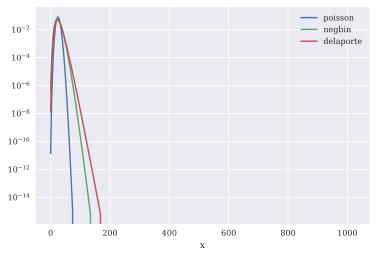

In [122]:
df, temp = gamma_mix(25, .25, 2, 10, logy=True)

In [148]:
def gamma_mix(n, cv, certain, log2, **kwds):
    
    def defuzz(x):
        x[np.abs(x) < 5e-16] = 0
        return x
    
    N = 1 << log2
    z = np.zeros(N)
    z[1] = 1
    fz = ft(z)
    
    # build poisson for comparison
    kernel = n * (fz - 1)
    p = np.real(ift(np.exp(kernel)))
    p = defuzz(p)
    
    # Var(G) = c, E(G)=1 so Var(G) = cv^2
    c = cv*cv
    # wikipedia / scipy stats use a and theta for shape and scale
    a = 1 / c
    θ = c
    nb = np.real(ift( (1 - θ * kernel) ** -a))
    nb = defuzz(nb)
    
    shift = certain
    a = ((1 - shift) / cv)**2
    θ = (1 - shift) / a
   
    delaporte = np.real(ift( np.exp(shift * kernel) *  (1 - θ * kernel) ** -a))
    delaporte = defuzz(delaporte)
    
    df = pd.DataFrame(dict(x=range(N), poisson=p, negbin=nb, delaporte=delaporte))
    f, ax = plt.subplots(1,2,figsize=(9,4))
    
    df.plot(kind='line', x='x', ax=ax[0], **kwds)
    df.plot(kind='line', x='x', logy=True, ax=ax[1], **kwds)

    # numerical moments 
    moms = lambda col :  ((df.x**k * df[col]).sum() for k in (1,2,3))
    pm1, pm2, pm3 = moms('poisson') 
    pm, pcv, psk = MomentAggregator._moments_to_mcvsk(pm1, pm2, pm3)
    nbm1, nbm2, nbm3 = moms('negbin')
    nbm, nbcv, nbsk = MomentAggregator._moments_to_mcvsk(nbm1, nbm2, nbm3)
    dm1, dm2, dm3 = moms('delaporte')
    dm, dcv, dsk = MomentAggregator._moments_to_mcvsk(dm1, dm2, dm3)
    
    # asymptotic moments 
    asNCV = np.sqrt(c)
    asNSK = 2 * cv
    delSK = 2 / np.sqrt(a)
   
    temp = pd.DataFrame(dict(cv=cv, certain=certain, a=a, θ=θ, shift=shift,   
                             pm=pm, pcv=pcv, psk=psk,
                             nbm=nbm, nbcv=nbcv, nbsk=nbsk, 
                             asNCV=asNCV, asNSK=asNSK, delSK=delSK,
                             dm=dm, dcv=dcv, dsk=dsk), 
                         index=[1])
    temp = temp.set_index(['cv', 'certain'])
    assert np.allclose([df[['poisson', 'negbin', 'delaporte']].sum()], 1)
    display(temp)
    return df, temp

,,a,θ,shift,pm,pcv,psk,nbm,nbcv,nbsk,asNCV,asNSK,delSK,dm,dcv,dsk
cv,certain,,,,,,,,,,,,,,,
1.5,0.5,0.111111,4.5,0.5,50.0,0.141421,0.141421,48.906392,1.445487,2.484275,1.5,3.0,6.0,47.16335,1.249756,4.009605


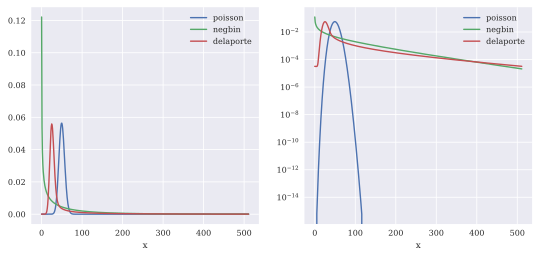

In [155]:
a, b = gamma_mix(50, 1.5, .5, 9)

In [189]:
def pig_mix(n, cv, certain, log2, **kwds):
    
    def defuzz(x):
        x[np.abs(x) < 5e-16] = 0
        return x
    
    N = 1 << log2
    z = np.zeros(N)
    z[1] = 1
    fz = ft(z)
    
    # build poisson for comparison
    kernel = n * (fz - 1)
    p = np.real(ift(np.exp(kernel)))
    p = defuzz(p)
    
    # Var(G) = c, E(G)=1 so Var(G) = cv^2
    c = cv*cv
    # wikipedia / scipy stats use a and theta for shape and scale
    μ = cv*cv
    λ = 1/μ
    fz = ss.invgauss(μ, scale=λ)
    print(fz.stats('mvs'))
    
    # not correct... 
    pig = np.real(ift( np.exp(λ / μ * (1 - np.sqrt(1 - 2 * μ**2 * kernel / λ) ))))  
    pig = defuzz(pig)
    
    shift = certain
    a = ((1 - shift) / cv)**2
    θ = (1 - shift) / a
   
    delaporte = np.real(ift( np.exp(shift * kernel) *  (1 - θ * kernel) ** -a))
    delaporte = defuzz(delaporte)
    
    df = pd.DataFrame(dict(x=range(N), poisson=p, pig=pig, delaporte=delaporte))
    f, ax = plt.subplots(1,2,figsize=(9,4))
    
    df.plot(kind='line', x='x', ax=ax[0], **kwds)
    df.plot(kind='line', x='x', logy=True, ax=ax[1], **kwds)

    # numerical moments 
    moms = lambda col :  ((df.x**k * df[col]).sum() for k in (1,2,3))
    pm1, pm2, pm3 = moms('poisson') 
    pm, pcv, psk = MomentAggregator._moments_to_mcvsk(pm1, pm2, pm3)
    pigm1, pigm2, pigm3 = moms('pig')
    pigm, pigcv, pigsk = MomentAggregator._moments_to_mcvsk(pigm1, pigm2, pigm3)
    dm1, dm2, dm3 = moms('delaporte')
    dm, dcv, dsk = MomentAggregator._moments_to_mcvsk(dm1, dm2, dm3)
    
    # asymptotic moments 
    asNCV = np.sqrt(c)
    asNSK = 2 * cv
    delSK = 2 / np.sqrt(a)
   
    temp = pd.DataFrame(dict(cv=cv, certain=certain, a=a, θ=θ, shift=shift,   
                             pm=pm, pcv=pcv, psk=psk,
                             pigm=pigm, pigcv=pigcv, pigsk=pigsk, 
                             asNCV=asNCV, asNSK=asNSK, delSK=delSK,
                             dm=dm, dcv=dcv, dsk=dsk), 
                         index=[1])
    temp = temp.set_index(['cv', 'certain'])
    assert np.allclose([df[['poisson', 'pig', 'delaporte']].sum()], 1)
    display(temp)
    return df, temp

(array(1.0), array(0.0625), array(0.75))


,,a,θ,shift,pm,pcv,psk,pigm,pigcv,pigsk,asNCV,asNSK,delSK,dm,dcv,dsk
cv,certain,,,,,,,,,,,,,,,
0.25,0.5,4.0,0.125,0.5,50.0,0.141421,0.141421,3.125,0.569128,0.576074,0.25,0.5,1.0,50.0,0.287228,0.834518


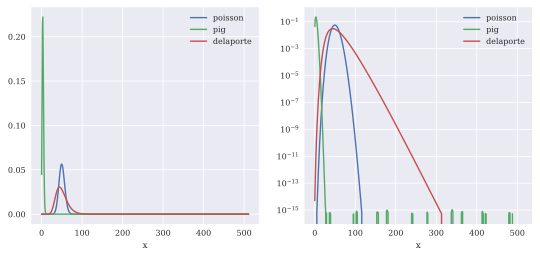

In [190]:
a, b = pig_mix(50, 0.25, .5, 9)

In [ ]:
def eg(cv, mean, log2, **kwds):
    N = 1<<log2
    z = np.zeros(N)
    z[1] = 1
    fz = ft(z)
    p = np.real(ift(np.exp(mean * (fz-1))))
    c2 = cv*cv
    k = 1/c2
    P = mean * c2
    nb = np.real(ift( (1+P-P*fz)**-k ))
    df = pd.DataFrame(dict(x=range(N), poisson=p, negbin=nb))
    df.plot(kind='line', x='x', **kwds)
    pm, pm2, pm3 = ((df.x**k * df.poisson).sum() for k in (1,2,3))
    nbm, nbm2, nbm3 = ((df.x**k * df.negbin).sum() for k in (1,2,3))
    pv = pm2 - pm*pm
    nbv = nbm2 - nbm*nbm
    c = (nbv/nbm-1)/nbm,
    display(pd.DataFrame(dict(k=k, P=P, pm=pm, pv=pv, nbm=nbm, nbv=nbv, enbv=mean*(1+cv*cv*mean), c=c, nbm3=nbm3, nbm3th=(k*P)**2*(3*(1+P)+P*k)+k*P*(1+P)*(1+2*P)), index=['Sample']))
    return df

a = eg(.81, 20, 10, logy=True)

(df.x**2 * df.poisson).sum()

from scipy.special import kv

kv(0.5, np.linspace(0,10,20))

def sichel(α, β, γ, log2, **kwds):
    N = 1<<log2
    z = np.zeros(N)
    z[1] = 1
    fz = ft(z)
    ξ = β / np.sqrt(1 - 2*β/α)
    ω = np.sqrt(ξ*ξ + α*α) - ξ
    kgo = kv(γ, ω)
    rad = np.sqrt(1-2*β*(fz-1))
    mean = ξ*kv(γ+1, ω)/kgo
    print(rad)
    p = np.real(ift(np.exp(mean * (fz-1))))
    sichel = np.real(ift( kv(γ, ω*rad) / (kgo * rad**γ) ))
    print(kv(γ, ω*rad))
    df = pd.DataFrame(dict(x=range(N), poisson=p, sichel=sichel))
    df.plot(kind='line', x='x', **kwds)
    pm, pm2, pm3 = ((df.x**k * df.poisson).sum() for k in (1,2,3))
    sichelm, sichelm2, sichelm3 = ((df.x**k * df.sichel).sum() for k in (1,2,3))
    pv = pm2 - pm*pm
    sichelv = sichelm2 - sichelm*sichelm
    display(pd.DataFrame(dict(α=α, β=β, γ=γ, ξ=ξ, ω=ω, pm=pm, pv=pv, sichelm=sichelm, sichelv=sichelv, cv=np.sqrt(sichelv) / sichelm), index=['Sample']))
    return df

sichel(10, 8, -0.5, 8)

def pois_pas(claims, claimants_per_claim, cv_claimants, log2, **kwds):
    N = 1<<log2
    z = np.zeros(N)
    z[1] = 1
    fz = ft(z)
    c2 = cv_claimants*cv_claimants
    k = 1/c2
    P = claimants_per_claim * c2
    θ = claims / claimants_per_claim
    p = np.real(ift(np.exp(claims * (fz-1))))  
#     nb = np.real(ift( (1+P-P*fz)**-k ))
    pois_pas = np.real(ift( np.exp(θ*((1+P-P*fz)**-k - 1))))
    df = pd.DataFrame(dict(x=range(N), poisson=p, pois_pas=pois_pas))
    df.plot(kind='line', x='x', **kwds)
    pm, pm2, pm3 = ((df.x**k * df.poisson).sum() for k in (1,2,3))
    pois_pasm, pois_pasm2, pois_pasm3 = ((df.x**k * df.pois_pas).sum() for k in (1,2,3))
    pv = pm2 - pm*pm
    pois_pasv = pois_pasm2 - pois_pasm*pois_pasm
    display(pd.DataFrame(dict(mean=claims, claimants=claimants_per_claim, cv_claimants=cv_claimants, k=k, P=P, θ=θ, pm=pm, pv=pv, pois_pasm=pois_pasm, pois_pasv=pois_pasv, cvest=np.sqrt(pois_pasv) / pois_pasm), index=['Sample']))
    return df

df = pois_pas(10, 1.1, 2, 8)

df = pois_pas(10, .55, 2.1, 8, logy=True)

In [180]:
cv = 0.25
μ = cv*cv
λ = 1/μ
fz = ss.invgauss(μ, scale=λ)

In [181]:
fz.stats('mvs')

(array(1.0), array(0.0625), array(0.75))

In [182]:
.25**2

0.0625

In [165]:
xs = np.linspace(0, 20, 101)

In [166]:
fxs = fz.pdf(xs)

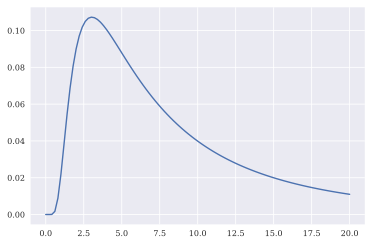

In [167]:
plt.plot(xs, fxs)

(array(1.0), array(1.0), array(3.0))

In [217]:
with open(r'C:\S\TELOS\Python\aggregate_project\aggregate\parser.py', 'r') as f:
    txt = f.read()
    

In [218]:
stxt = txt.split('@_')

In [219]:
print(stxt[13])

('MIXED ID numbers numbers')
    def freq(self, p):
        self.p(f'MIXED ids numbers numbers {p.ID}, {p.numbers}, {p.numbers} two param freq, numbers.1=CVs')
        return {'freq_name': p.ID, 'freq_a': p[2], 'freq_b': p[3]}  # TODO IDS--> poisson for now

    


In [220]:
ans = {}
for it in stxt[3:]:
    b = it.split('def')
    b0 = b[0].strip()[2:-2]
    b1 = b[1].split("(self, p):")[0].strip()
    if b1 in ans:
        ans[b1] += [b0]
    else:
        ans[b1] = [b0]


In [221]:
s = ''
for k, v in ans.items():
    s += f'{k:<20s}\t:: {v[0]:<s}\n'
    for rhs in v[1:]:
        s += f'{" "*20}\t | {rhs:<s}\n'
    s += '\n'
print(s)

answer              	:: sev_out
                    	 | agg_out
                    	 | port_out

port_out            	:: port_name agg_list

agg_list            	:: agg_list agg_out
                    	 | agg_out

agg_out             	:: agg_name builtin_aggregate
                    	 | agg_name exposures layers SEV sev freq

sev_out             	:: sev_out sev_name sev
                    	 | sev_name sev

freq                	:: MIXED ID numbers numbers
                    	 | MIXED ID numbers
                    	 | FIXED
                    	 | POISSON
                    	 | 

sev                 	:: sev PLUS numbers
                    	 | sev MINUS numbers
                    	 | numbers TIMES sev
                    	 | ids numbers CV numbers weights
                    	 | ids numbers weights
                    	 | ids numbers numbers weights xps
                    	 | ids xps
                    	 | builtinids

xps                 	:: XPS numbers numbers
                

In [214]:
ans

{'agg_list': ['agg_list agg_out', 'agg_out'],
 'agg_name': ['AGG ID', 'ID'],
 'agg_out': ['agg_name builtin_aggregate',
  'agg_name exposures layers SEV sev freq'],
 'answer': ['sev_out', 'agg_out', 'port_out'],
 'builtin_aggregate': ['builtin_aggregate_dist TIMES NUMBER',
  'NUMBER TIMES builtin_aggregate_dist',
  'builtin_aggregate_dist'],
 'builtin_aggregate_dist': ['BUILTINID'],
 'builtinidl': ["builtinidl BUILTINID')\n   ", "BUILTINID')\n   "],
 'builtinids': ['"[" builtinidl "]"\')\n   ', 'BUILTINID'],
 'exposures': ['numbers CLAIMS',
  'numbers LOSS',
  'numbers PREMIUM AT numbers LR',
  'numbers PREMIUM AT numbers'],
 'freq': ['MIXED ID numbers numbers',
  'MIXED ID numbers',
  'FIXED',
  'POISSON',
  ''],
 'idl': ['idl ID', 'ID'],
 'ids': ['"[" idl "]"', 'ID'],
 'layers': ['numbers XS numbers', ''],
 'numberl': ['numberl NUMBER', 'NUMBER'],
 'numbers': ['"[" numberl "]"', 'NUMBER'],
 'port_name': ['PORT ID'],
 'port_out': ['port_name agg_list'],
 'sev': ['sev PLUS numbers',
  